In [1]:
from desc.transform import Transform
from desc.equilibrium import Equilibrium
from desc.basis import ChebyshevZernikeBasis, chebyshev_z
from desc.compute import compute
from desc.grid import LinearGrid, ConcentricGrid, QuadratureGrid, Grid
from desc.compute.utils import get_transforms
from desc.objectives import (
    FixEndCapLambda,
    FixEndCapR,
    FixEndCapZ,
    FixBoundaryR,
    FixBoundaryZ,
    FixPsi,
    FixPressure,
    FixIota,
    ForceBalance,
    ObjectiveFunction,
    CurrentDensity
)
import numpy as np
from desc.optimize import Optimizer
from desc.profiles import PowerSeriesProfile
from desc.geometry import FourierRZToroidalSurface
from desc.plotting import plot_section, plot_3d, plot_surfaces, plot_2d, plot_boundary, plot_1d
from matplotlib import pyplot as plt 

DESC version 0+untagged.5778.g9e20b74.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 1.43 GB available memory


In [2]:
def chebygrid(N_grid):
    return np.concatenate( ([0],(-np.cos( (2 * np.arange(N_grid) + 1) * np.pi / (2 *  N_grid) ) + 1) * np.pi / 2,[np.pi]))
def grid_gen(L_grid, M_grid, N_grid, node_pattern="jacobi"):
    LMnodes = ConcentricGrid(L=L_grid,M=M_grid,N=0, node_pattern=node_pattern).nodes[:,:2]
    Nnodes = chebygrid(N_grid)
    lm = np.tile(LMnodes, (Nnodes.size,1))
    n = np.tile(Nnodes.reshape(-1,1), (1, LMnodes.shape[0])).reshape(-1,1)
    nodes = np.concatenate((lm,n), axis=1)
    return Grid(nodes)

In [3]:
def get_lm_mode(basis, coeff, zeta, L, M, func_zeta=chebyshev_z):
    modes = basis.modes
    lm =0
    for i, (l, m, n) in enumerate(modes):
        if l == L and m == M:
            lm += func_zeta(zeta, n)*coeff[i]
    return lm

# Free End Cap condition

In [4]:
from scipy.constants import mu_0

In [5]:
surf = FourierRZToroidalSurface(
    R_lmn=[10,1,-0.2],
    modes_R=[[0,0],[1,0],[2,1]],
    Z_lmn=[0,-1,0.2],
    modes_Z=[[0,0],[-1,0],[-2,1]],
    NFP=1,
    sym=False,
    mirror=True,
    length=np.pi/2
)

p = PowerSeriesProfile(params=[0.00/mu_0, -0.00/mu_0], modes=[0, 2])
iota = PowerSeriesProfile(params=[0, 0])
eq = Equilibrium(
    surface=surf,
    L=5,
    M=2,
    N=6,
    mirror=True,
    pressure=p,
    iota=iota,
    sym=False,
    method="jitable",
    length=np.pi/2,
)

constraints = (
        # FixEndCapLambda(0, eq=eq),
        # FixEndCapR(0, eq.eq),
        # FixEndCapZ(0, eq=eq),
        # FixEndCapLambda(2*np.pi, eq=eq),
        # FixEndCapR(2*np.pi, eq=eq),
        # FixEndCapZ(2*np.pi, eq=eq),
        FixBoundaryR(eq=eq),
        FixBoundaryZ(eq=eq),
        FixPressure(eq=eq),
        FixIota(eq=eq),
        FixPsi(eq=eq),
    )
optimizer = Optimizer("lsq-exact")
grid = grid_gen(10,4,10)
# objectives = CurrentDensity(eq=eq, grid=grid)
objectives = ForceBalance(eq=eq, grid=grid)
obj = ObjectiveFunction(objectives=objectives)

In [6]:
eq.solve(
    objective=obj,
    constraints=constraints,
    optimizer=optimizer,
    ftol=1e-6,
    xtol=1e-16,
    gtol=1e-16,
);

Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 203
Number of objectives: 768
Starting optimization
Using method: lsq-exact
         Current function value: 2.419e-04
         Total delta_x: 1.687e+00
         Iterations: 100
         Function evaluations: 119
         Jacobian evaluations: 101
Start of solver
Total (sum of squares):  2.184e+00, 
Maximum absolute Force error:  6.389e+06 (N)
Minimum absolute Force error:  1.295e-11 (N)
Average absolute Force error:  2.833e+05 (N)
Maximum absolute Force error:  4.014e-01 (normalized)
Minimum absolute Force error:  8.139e-19 (normalized)
Average absolute Force error:  1.780e-02 (normalized)
End of solver
Total (sum of squares):  2.419e-04, 
Maximum absolute Force error:  3.846e+04 (N)
Minimum absolute Force error:  9.864e+00 (N)
Average absolute Force error:  3.511e+03 (N)
Maximum absolute Force error:  2.417e-03 (normalized)
Minimum absolute Force error:  6.1

In [7]:
eq.save("mirror_test.h5")

(<Figure size 431.653x431.653 with 2 Axes>,
 <Axes3D: title={'center': '$\\alpha~(~)$'}, xlabel='$X ~(\\mathrm{m})$', ylabel='$Y ~(\\mathrm{m})$', zlabel='$Z ~(\\mathrm{m})$'>)

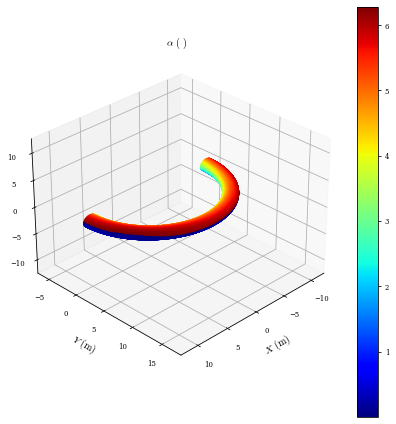

In [14]:
plot_3d(eq, "alpha", azim=45, grid=LinearGrid(theta=np.linspace(0,2*np.pi,100), zeta=np.linspace(0,np.pi,100)))

In [8]:
get_lm_mode(eq.L_basis, eq.L_lmn, 2*np.pi, 1 ,-1)

Array(-5.71699806e-16, dtype=float64)

(<Figure size 287.769x287.769 with 1 Axes>,
 <Axes: xlabel='$\\rho$', ylabel='$ p ~(Pa)$'>)

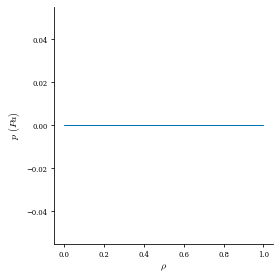

In [9]:
plot_1d(eq, "p")

/Users/xchu/Apps/miniconda3/envs/desc-mirror/lib/python3.11/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/xchu/Apps/miniconda3/envs/desc-mirror/lib/python3.11/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


(<Figure size 1079.13x719.422 with 11 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.250$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.750$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Ax

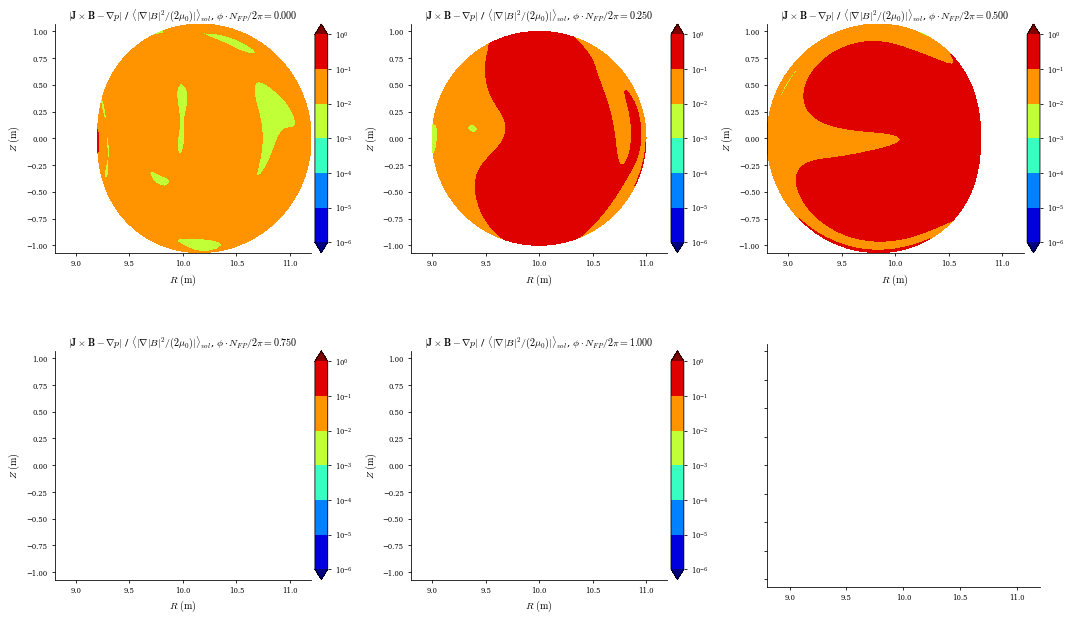

In [10]:
plot_section(eq, "|F|", norm_F=True, log=True, grid=LinearGrid(L=50,M=50,N=2,endpoint=True))

In [44]:
from desc.plotting import plot_field_lines_real_space, plot_field_lines_sfl

(<Figure size 863.306x719.422 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.200$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.400$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.600$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.800$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 1.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

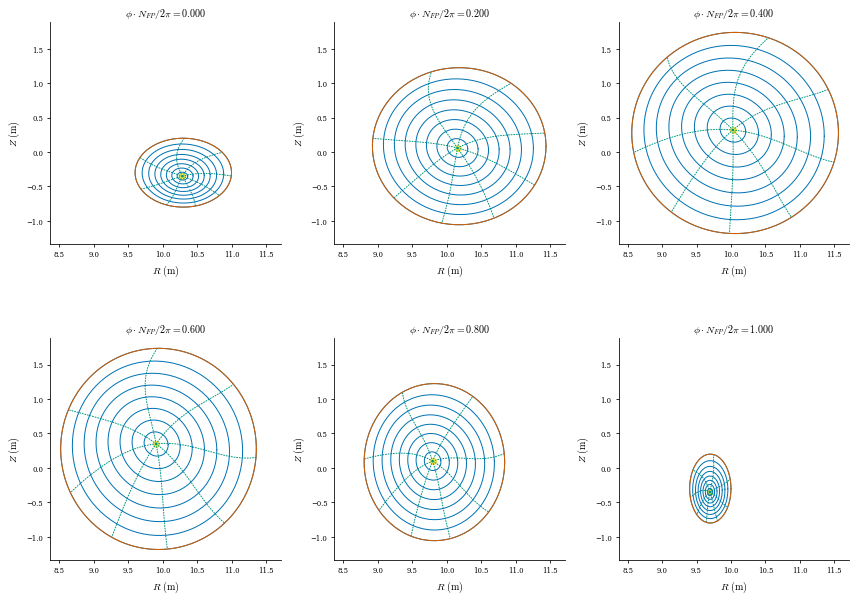

In [64]:
plot_surfaces(eq, phi=np.linspace(0,2*np.pi,6, endpoint=True))

(<Figure size 863.306x575.538 with 2 Axes>,
 <Axes3D: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$X ~(\\mathrm{m})$', ylabel='$Y ~(\\mathrm{m})$', zlabel='$Z ~(\\mathrm{m})$'>)

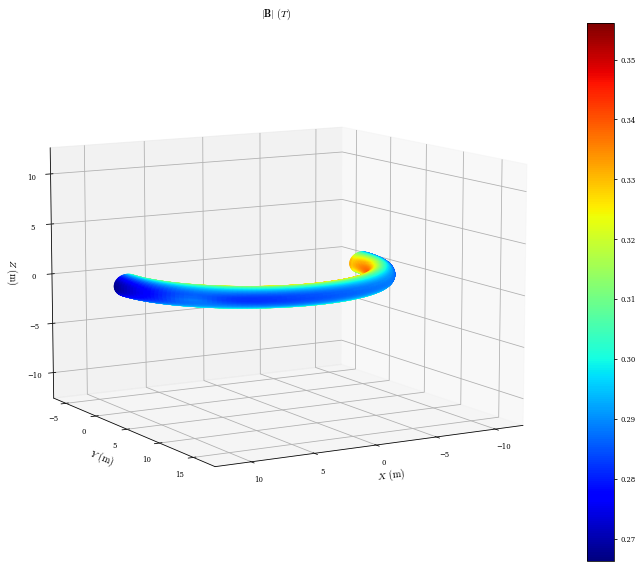

In [13]:
plot_3d(eq, "|B|", grid=LinearGrid(theta=np.linspace(0,2*np.pi,100), zeta=np.linspace(0,np.pi,100)), azim=60, elev=10, figsize=(12,8))

(<Figure size 1438.84x719.422 with 15 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{B}|$ ($T$), $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{B}|$ ($T$), $\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{B}|$ ($T$), $\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{B}|$ ($T$), $\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{B}|$ ($T$), $\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{B}|$ ($T$), $\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center':

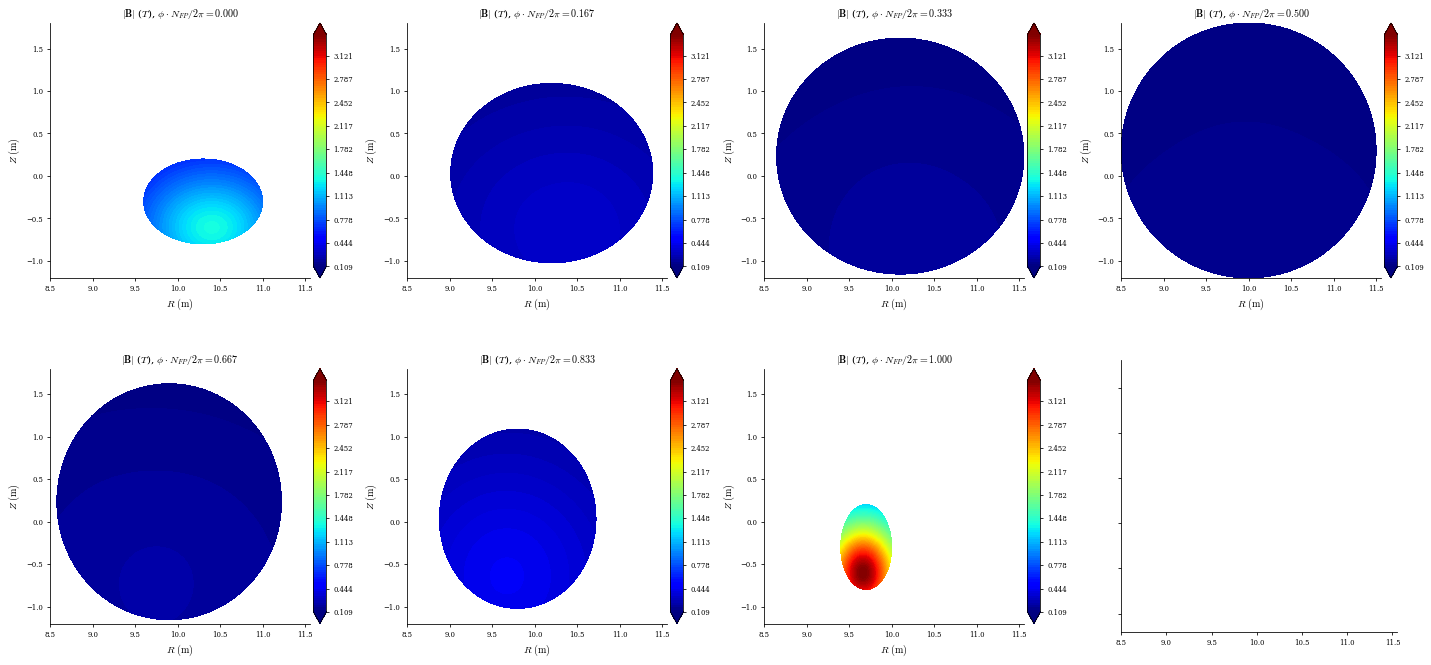

In [65]:
plot_section(eq, "|B|", grid=LinearGrid(L=50,M=50,N=3,endpoint=True))

(<Figure size 431.653x431.653 with 1 Axes>,
 <Axes: xlabel='$\\rho$', ylabel='$Z~(m)$'>)

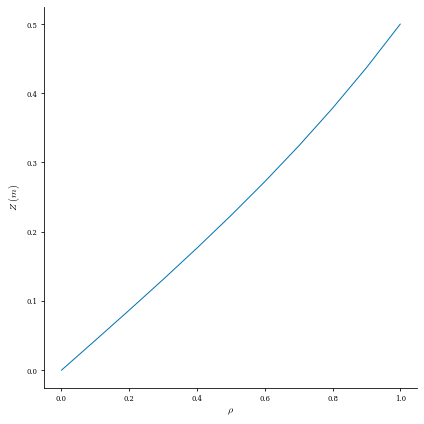

In [60]:
plot_1d(eq, "Z", LinearGrid(L=10, theta=[-np.pi/2], zeta=[0]))

# Fix End Cap boundary condition

In [13]:
surf = FourierRZToroidalSurface(
    R_lmn=[10,1,-0.5],
    modes_R=[[0,0],[1,0],[1,2]],
    Z_lmn=[0,-1,0.5],
    modes_Z=[[0,0],[-1,0],[-1,2]],
    NFP=1,
    sym=False,
    mirror=True
)

p = PowerSeriesProfile(params=[0, 0], modes=[0, 2])
iota = PowerSeriesProfile(params=[0.1, 0])
eq = Equilibrium(
    surface=surf,
    L=7,
    M=1,
    N=8,
    mirror=True,
    pressure=p,
    iota=iota,
    sym=False,
    method="jitable",
)

constraints = (
        FixEndCapLambda(0, eq=eq),
        FixEndCapR(0, eq=eq),
        FixEndCapZ(0, eq=eq),
        FixEndCapLambda(2*np.pi, eq=eq),
        FixEndCapR(2*np.pi, eq=eq),
        FixEndCapZ(2*np.pi, eq=eq),
        FixBoundaryR(eq=eq),
        FixBoundaryZ(eq=eq),
        FixPressure(eq=eq),
        FixIota(eq=eq),
        FixPsi(eq=eq),
    )
optimizer = Optimizer("lsq-exact")
grid = grid_gen(14,2,2)
# objectives = CurrentDensity(eq=eq, grid=grid)
objectives = ForceBalance(eq=eq, grid=grid)
obj = ObjectiveFunction(objectives=objectives)

In [14]:
eq.solve(
    objective=obj,
    constraints=constraints,
    optimizer=optimizer,
    ftol=1e-6,
    xtol=1e-16,
    gtol=1e-16,
);

Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 210
Number of objectives: 192
Starting optimization
Using method: lsq-exact
         Current function value: 8.497e-11
         Total delta_x: 5.126e-01
         Iterations: 100
         Function evaluations: 118
         Jacobian evaluations: 101
Start of solver
Total (sum of squares):  1.092e+00, 
Maximum absolute Force error:  9.704e+05 (N)
Minimum absolute Force error:  1.766e-12 (N)
Average absolute Force error:  1.001e+05 (N)
Maximum absolute Force error:  1.207e-01 (normalized)
Minimum absolute Force error:  2.197e-19 (normalized)
Average absolute Force error:  1.245e-02 (normalized)
End of solver
Total (sum of squares):  8.497e-11, 
Maximum absolute Force error:  2.307e+01 (N)
Minimum absolute Force error:  1.152e-04 (N)
Average absolute Force error:  6.821e-01 (N)
Maximum absolute Force error:  2.870e-06 (normalized)
Minimum absolute Force error:  1.4

(<Figure size 575.538x575.538 with 2 Axes>,
 <Axes3D: title={'center': '$\\alpha~(~)$'}, xlabel='$X ~(\\mathrm{m})$', ylabel='$Y ~(\\mathrm{m})$', zlabel='$Z ~(\\mathrm{m})$'>)

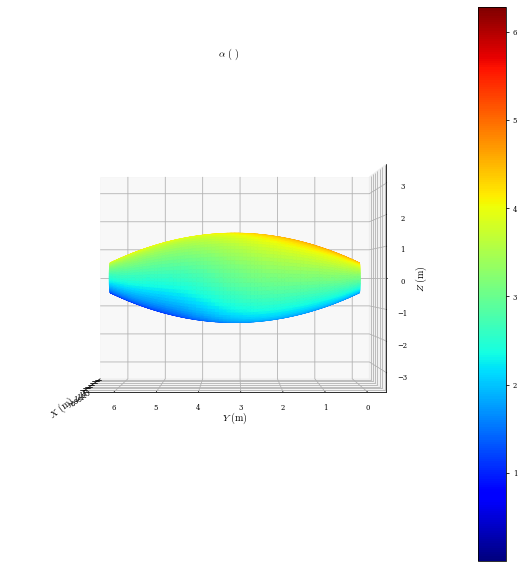

In [19]:
plot_3d(eq, "alpha", azim=180,elev=0, figsize=(8,8))

(<Figure size 719.422x359.711 with 4 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 1.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

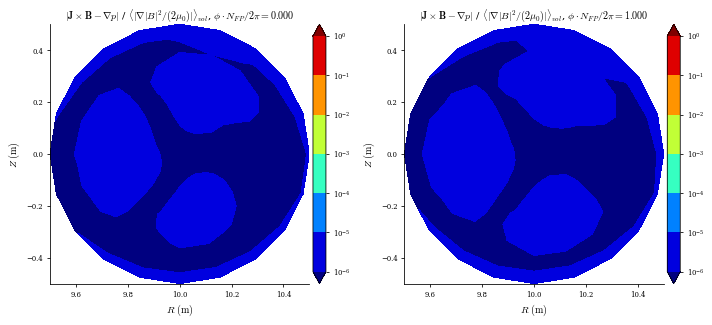

In [38]:
plot_section(eq,"|F|", norm_F=True, log=True, grid=LinearGrid(L=10,M=10,zeta=[0,2*np.pi],endpoint=True))

(<Figure size 1079.13x719.422 with 12 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Ax

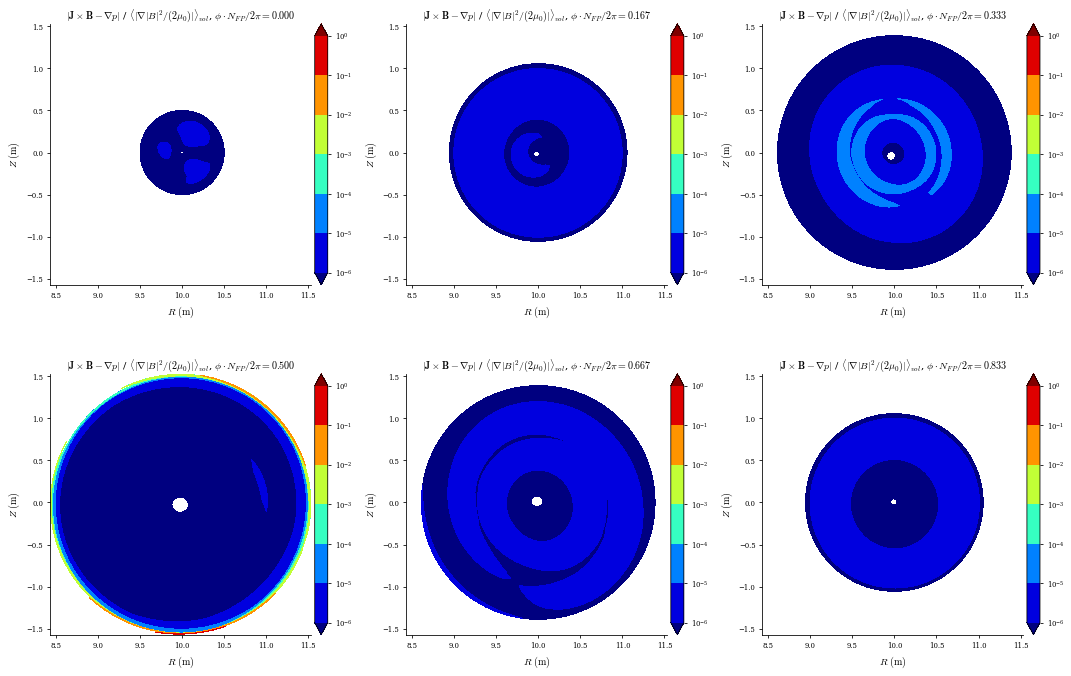

In [20]:
plot_section(eq,"|F|", norm_F=True, log=True)

# Compute tests

In [28]:
grid = LinearGrid(L=3,M=3,N=3)

In [33]:
tranf = Transform(basis=eq.R_basis,grid=grid,method="jitable")
# jitable is direct1

In [40]:
get_transforms("B",eq,grid,jitable=True)

{'grid': LinearGrid at 0x291c07d50 (L=3, M=3, N=3, NFP=1, sym=False, node_pattern=linear),
 'R': Transform at 0x293124350 (method=jitable, basis=ChebyshevZernikeBasis at 0x17f9a5890 (L=3, M=3, N=3, NFP=1, sym=False, spectral_indexing=ansi), grid=LinearGrid at 0x291c07d50 (L=3, M=3, N=3, NFP=1, sym=False, node_pattern=linear)),
 'Z': Transform at 0x293195c90 (method=jitable, basis=ChebyshevZernikeBasis at 0x17f7c8590 (L=3, M=3, N=3, NFP=1, sym=False, spectral_indexing=ansi), grid=LinearGrid at 0x291c07d50 (L=3, M=3, N=3, NFP=1, sym=False, node_pattern=linear)),
 'L': Transform at 0x29315acd0 (method=jitable, basis=ChebyshevZernikeBasis at 0x174a4da90 (L=3, M=3, N=3, NFP=1, sym=False, spectral_indexing=ansi), grid=LinearGrid at 0x291c07d50 (L=3, M=3, N=3, NFP=1, sym=False, node_pattern=linear))}

In [42]:
eq.compute("B")["B"]

Array([[0.        , 0.31830989, 0.        ],
       [0.        , 0.31830989, 0.        ],
       [0.        , 0.31830989, 0.        ],
       ...,
       [0.        , 0.31830989, 0.        ],
       [0.        , 0.31830989, 0.        ],
       [0.        , 0.31830989, 0.        ]], dtype=float64)